In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML
import seaborn as sns
import numpy as np
from scipy.interpolate import interp1d
%load_ext autoreload
%autoreload 2
import numpy as np
from easing import easing
import pandas as pd
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
directory_path = r'C:\Users\darkc\OneDrive\Documents\MICA\Viz in Practice\Viz_In_Practice'
os.chdir(directory_path)

In [4]:
cp = pd.read_csv('Children in poverty.csv')
ei = pd.read_csv('EITC_data.csv')

In [5]:
abs_cp = cp[cp['DataFormat'] == 'Number'].copy()
prct_df = cp[cp['DataFormat'] == 'Percent'].copy()
abs_cp = abs_cp.rename(columns={'Data': 'Children_in_Poverty'})
abs_cp = abs_cp.drop('DataFormat', axis=1)
prct_df = prct_df.rename(columns={'Data': 'Percent_Child_Poverty'})
prct_df = prct_df.drop('DataFormat', axis=1)
cp2 = pd.merge(abs_cp, prct_df, on=['Location', 'TimeFrame'])
cp2 = cp2.drop('LocationType_y', axis=1)

In [6]:
print(cp2.head())

  LocationType_x       Location  TimeFrame Children_in_Poverty  \
0         Nation  United States       2000            12209000   
1          State        Alabama       2000              233000   
2          State         Alaska       2000               25000   
3          State        Arizona       2000              310000   
4          State       Arkansas       2000              168000   

  Percent_Child_Poverty  
0                  0.17  
1                  0.21  
2                  0.13  
3                  0.23  
4                  0.25  


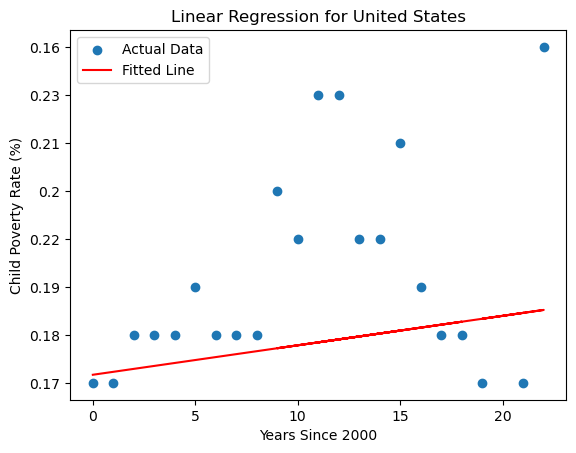

In [7]:
cp2 = cp2[cp2['Location'] != 'Puerto Rico']
cp2_states = cp2[cp2['LocationType_x'] == 'State']

states = cp2['Location'].unique()

regression_results = []

def custom_linregress(x, y, intercept):
    slope, _, r_value, _, _ = linregress(x, y)
    return slope * x + intercept, r_value

for state in states:
    state_data = cp2[cp2['Location'] == state]

    if len(state_data) > 1:

        years_since_2000 = state_data['TimeFrame'] - 2000  # Use years since 2000 as x-values
        percent_poverty_values = pd.to_numeric(state_data['Percent_Child_Poverty'], errors='coerce')

        adjusted_values = percent_poverty_values - percent_poverty_values[state_data['TimeFrame'] == 2000].values[0]

        cleaned_data = pd.DataFrame({'YearsSince2000': years_since_2000, 'Values': adjusted_values}).dropna()

        intercept = percent_poverty_values[state_data['TimeFrame'] == 2000].values[0]
        fitted_values, r_value = custom_linregress(cleaned_data['YearsSince2000'], cleaned_data['Values'], intercept)

        regression_results.append({
            'State': state,
            'Intercept (2000)': intercept,
            'Slope': r_value,
        })

example_state = regression_results[0]['State']
example_data = cp2[cp2['Location'] == example_state]
plt.scatter(example_data['TimeFrame'] - 2000, example_data['Percent_Child_Poverty'], label='Actual Data')
plt.plot(example_data['TimeFrame'] - 2000, regression_results[0]['Intercept (2000)'] + regression_results[0]['Slope'] * (example_data['TimeFrame'] - 2000), color='red', label='Fitted Line')
plt.xlabel('Years Since 2000')
plt.ylabel('Child Poverty Rate (%)')
plt.title(f'Linear Regression for {example_state}')
plt.legend()
plt.show()

In [8]:
regression_results_df = pd.DataFrame(regression_results)
regression_results_df.head()

,State,Intercept (2000),Slope
0,United States,0.17,0.061395
1,Alabama,0.21,0.098493
2,Alaska,0.13,0.413285
3,Arizona,0.23,-0.061900
4,Arkansas,0.25,-0.074645


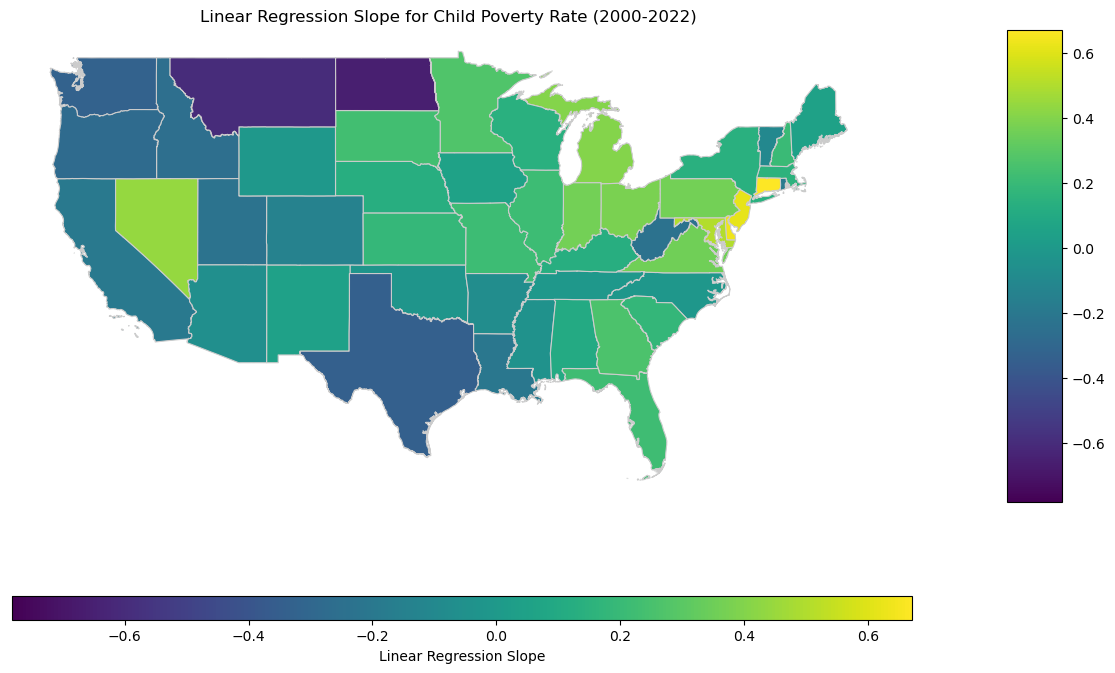

In [9]:
regression_results_df = pd.DataFrame(regression_results)

regression_results_df1 = regression_results_df[(regression_results_df['State'].isin(['Alaska', 'Hawaii']) == False)].copy()

shapefile_path = 'cb_2018_us_state_500k.shp'
usa = gpd.read_file(shapefile_path)

# Merge shapefile with regression results
merged_df = usa.merge(regression_results_df1, left_on='NAME', right_on='State')

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(15, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot the slope on the map for each state
merged_df.plot(column='Slope', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax=cax)

ax.set_title('Linear Regression Slope for Child Poverty Rate (2000-2022)')
ax.set_axis_off()

# Add a colorbar directly to the plot
cax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=merged_df['Slope'].min(), vmax=merged_df['Slope'].max()))
sm._A = []
fig.colorbar(sm, cax=cax, orientation='horizontal', label="Linear Regression Slope")

plt.show()


In [10]:
cp2['Year'] = pd.to_numeric(cp2['TimeFrame'], errors='coerce')
cp2_filtered = cp2[cp2['TimeFrame'] >= 2000].copy()
cp2_filtered.sort_values(by=['Location', 'TimeFrame'], inplace=True)
cp2_filtered['Children_in_Poverty'] = pd.to_numeric(cp2_filtered['Children_in_Poverty'], errors='coerce')
cp2_filtered['Percent_Child_Poverty'] = pd.to_numeric(cp2_filtered['Percent_Child_Poverty'], errors='coerce')

In [11]:
# YOY Child Poverty
cp2_filtered['YoY_Change_Absolute_Poverty'] = cp2_filtered.groupby('Location')['Children_in_Poverty'].diff()

cp2_filtered['YoY_Pct_Change_Absolute_Poverty'] = (
    cp2_filtered.groupby('Location')['Children_in_Poverty']
    .pct_change(fill_method=None) * 100
)

cp2_filtered['YoY_Child_Poverty_Percent'] = cp2_filtered.groupby('Location')['Percent_Child_Poverty'].diff()


In [12]:
print(cp2_filtered.head())

    LocationType_x Location  TimeFrame  Children_in_Poverty  \
1            State  Alabama       2000               233000   
104          State  Alabama       2001               253000   
107          State  Alabama       2002               255000   
210          State  Alabama       2003               255000   
213          State  Alabama       2004               249000   

     Percent_Child_Poverty  Year  YoY_Change_Absolute_Poverty  \
1                     0.21  2000                          NaN   
104                   0.23  2001                      20000.0   
107                   0.24  2002                       2000.0   
210                   0.24  2003                          0.0   
213                   0.23  2004                      -6000.0   

     YoY_Pct_Change_Absolute_Poverty  YoY_Child_Poverty_Percent  
1                                NaN                        NaN  
104                         8.583691                       0.02  
107                         0.79

In [13]:
cp2_fstate = cp2_filtered[cp2_filtered['LocationType_x'] == 'State'].copy()
cp2_fus = cp2_filtered[cp2_filtered['LocationType_x'] == 'Nation'].copy()

In [14]:
ei_lagged = ei.copy()
ei_lagged['data_Lagged'] = ei_lagged.groupby('statecode')['data'].shift(-1)

ei_lagged.head()

,EITC_id,dataset,statecode,statistic,statid,year,data,Statename,NDecimals,StateAbbrev,data_Lagged
0,1,EIC,99,EIC_totalreturns_state,301,1995,19344000.0,United States,2.0,US,19404580.0
1,2,EIC,99,EIC_totalreturns_state,301,1996,19404580.0,United States,2.0,US,19817658.0
2,3,EIC,1,EIC_totalreturns_state,301,1996,455700.0,Alabama,2.0,AL,460087.0
3,4,EIC,2,EIC_totalreturns_state,301,1996,29163.0,Alaska,2.0,AK,30442.0
4,5,EIC,3,EIC_totalreturns_state,301,1996,340744.0,Arizona,2.0,AZ,347168.0


In [15]:
## Merge into one dataset (states)

merged_data = pd.merge(
    cp2_fstate,  # Use the filtered cp2 DataFrame for states only
    ei_lagged[ei_lagged['statistic'] == 'EIC_totalreturns_state'],
    left_on=['Location', 'TimeFrame'],
    right_on=['Statename', 'year']
)

print(merged_data.head())

  LocationType_x Location  TimeFrame  Children_in_Poverty  \
0          State  Alabama       2000               233000   
1          State  Alabama       2001               253000   
2          State  Alabama       2002               255000   
3          State  Alabama       2003               255000   
4          State  Alabama       2004               249000   

   Percent_Child_Poverty  Year  YoY_Change_Absolute_Poverty  \
0                   0.21  2000                          NaN   
1                   0.23  2001                      20000.0   
2                   0.24  2002                       2000.0   
3                   0.24  2003                          0.0   
4                   0.23  2004                      -6000.0   

   YoY_Pct_Change_Absolute_Poverty  YoY_Child_Poverty_Percent  EITC_id  \
0                              NaN                        NaN      211   
1                         8.583691                       0.02      263   
2                         0.7905

In [16]:
selected_columns = ['YoY_Child_Poverty_Percent', 'YoY_Change_Absolute_Poverty', 'YoY_Pct_Change_Absolute_Poverty', 'Children_in_Poverty', 'data']

correlation_matrix = merged_data[selected_columns].corr()

print(correlation_matrix)

                                 YoY_Child_Poverty_Percent  \
YoY_Child_Poverty_Percent                         1.000000   
YoY_Change_Absolute_Poverty                       0.573939   
YoY_Pct_Change_Absolute_Poverty                   0.898369   
Children_in_Poverty                               0.020045   
data                                              0.016402   

                                 YoY_Change_Absolute_Poverty  \
YoY_Child_Poverty_Percent                           0.573939   
YoY_Change_Absolute_Poverty                         1.000000   
YoY_Pct_Change_Absolute_Poverty                     0.550222   
Children_in_Poverty                                 0.254184   
data                                                0.258633   

                                 YoY_Pct_Change_Absolute_Poverty  \
YoY_Child_Poverty_Percent                               0.898369   
YoY_Change_Absolute_Poverty                             0.550222   
YoY_Pct_Change_Absolute_Poverty       

The amount of children in poverty is positively correlated with the amount of money given out.
The %change in poverty is not a

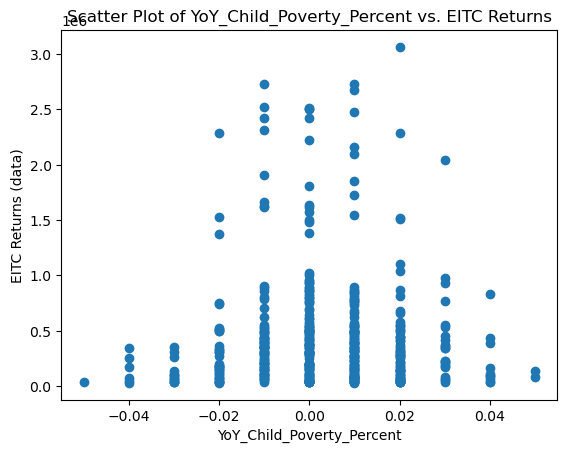

In [17]:
plt.scatter(merged_data['YoY_Child_Poverty_Percent'], merged_data['data'])
plt.title('Scatter Plot of YoY_Child_Poverty_Percent vs. EITC Returns')
plt.xlabel('YoY_Child_Poverty_Percent')
plt.ylabel('EITC Returns (data)')
plt.show()

In [18]:
## Merge into one dataset (states)

merged_us_data = pd.merge(
    cp2_fus,
    ei_lagged[ei_lagged['statistic'] == 'EIC_totalreturns_state'],
    left_on=['Location', 'TimeFrame'],
    right_on=['Statename', 'year']
)

merged_us_data.head()

,LocationType_x,Location,TimeFrame,Children_in_Poverty,Percent_Child_Poverty,Year,YoY_Change_Absolute_Poverty,YoY_Pct_Change_Absolute_Poverty,YoY_Child_Poverty_Percent,EITC_id,dataset,statecode,statistic,statid,year,data,Statename,NDecimals,StateAbbrev,data_Lagged
0,Nation,United States,2000,12209000,0.17,2000,NaN,NaN,NaN,210,EIC,99,EIC_totalreturns_state,301,2000,19166052.0,United States,2.0,US,19656992.0
1,Nation,United States,2001,11962000,0.17,2001,-247000.0,-2.023098,0.00,262,EIC,99,EIC_totalreturns_state,301,2001,19656992.0,United States,2.0,US,21574486.0
2,Nation,United States,2002,12518000,0.18,2002,556000.0,4.648052,0.01,314,EIC,99,EIC_totalreturns_state,301,2002,21574486.0,United States,2.0,US,22111802.0
3,Nation,United States,2003,12673000,0.18,2003,155000.0,1.238217,0.00,366,EIC,99,EIC_totalreturns_state,301,2003,22111802.0,United States,2.0,US,22418110.0
4,Nation,United States,2004,13245000,0.18,2004,572000.0,4.513533,0.00,418,EIC,99,EIC_totalreturns_state,301,2004,22418110.0,United States,2.0,US,22747632.0


In [19]:
us_correlation_matrix = merged_us_data[selected_columns].corr()

print(us_correlation_matrix)

                                 YoY_Child_Poverty_Percent  \
YoY_Child_Poverty_Percent                         1.000000   
YoY_Change_Absolute_Poverty                       0.771293   
YoY_Pct_Change_Absolute_Poverty                   0.767906   
Children_in_Poverty                               0.499236   
data                                              0.411911   

                                 YoY_Change_Absolute_Poverty  \
YoY_Child_Poverty_Percent                           0.771293   
YoY_Change_Absolute_Poverty                         1.000000   
YoY_Pct_Change_Absolute_Poverty                     0.999198   
Children_in_Poverty                                 0.712060   
data                                                0.567201   

                                 YoY_Pct_Change_Absolute_Poverty  \
YoY_Child_Poverty_Percent                               0.767906   
YoY_Change_Absolute_Poverty                             0.999198   
YoY_Pct_Change_Absolute_Poverty       

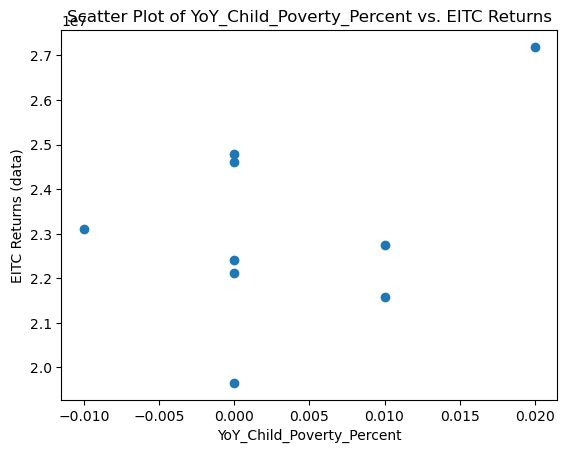

In [20]:
plt.scatter(merged_us_data['YoY_Child_Poverty_Percent'], merged_us_data['data'])
plt.title('Scatter Plot of YoY_Child_Poverty_Percent vs. EITC Returns')
plt.xlabel('YoY_Child_Poverty_Percent')
plt.ylabel('EITC Returns (data)')
plt.show()

In [22]:
sorted_data = merged_us_data.sort_values(by='TimeFrame')

sorted_data = sorted_data.dropna(subset=['YoY_Change_Absolute_Poverty', 'YoY_Pct_Change_Absolute_Poverty'])

fig, ax = plt.subplots()
sc = ax.scatter([], [])

ax.set_xlabel('YoY_Child_Poverty_Percent')
ax.set_ylabel('EITC Returns (data)')
ax.set_title('Scatter Plot of YoY_Child_Poverty_Percent vs. EITC Returns')


# Calculate the buffer size
x_buffer = 0.05 * (sorted_data['YoY_Child_Poverty_Percent'].max() - sorted_data['YoY_Child_Poverty_Percent'].min())
y_buffer = 0.05 * (sorted_data['data'].max() - sorted_data['data'].min())

# Set the limits with the buffer
ax.set_xlim(sorted_data['YoY_Child_Poverty_Percent'].min() - x_buffer, sorted_data['YoY_Child_Poverty_Percent'].max() + x_buffer)
ax.set_ylim(sorted_data['data'].min() - y_buffer, sorted_data['data'].max() + y_buffer)



def update(frame):
    if frame == 0:
        return sc,
    x_values = sorted_data['YoY_Child_Poverty_Percent'].iloc[:frame].values
    y_values = sorted_data['data'].iloc[:frame].values
    sc.set_offsets(np.column_stack((x_values, y_values)))
    return sc,


animation = FuncAnimation(fig, update, frames=len(sorted_data)+1, interval=1000, blit=True)

#animation.save('scatter_animation.gif', writer='imagemagick')
video = animation.to_html5_video()
html = display(HTML(video))

display(html)


plt.close()

None

In [ ]:
print(sorted_data.head())

In [25]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

# Assuming your data is stored in the variable 'sorted_data'
sorted_data = merged_us_data.sort_values(by='TimeFrame')

# Filter data if needed
sorted_data = sorted_data.dropna(subset=['YoY_Change_Absolute_Poverty', 'YoY_Pct_Change_Absolute_Poverty'])

fig, ax = plt.subplots()
line, = ax.plot([], [], marker='o', linestyle='-', color='b')

ax.set_xlabel('Year')
ax.set_ylabel('YoY Child Poverty Percent')
ax.set_title('Line Plot of YoY Child Poverty Percent Over Time')

# Calculate the buffer size
x_buffer = 0.05 * (sorted_data['Year'].max() - sorted_data['Year'].min())
y_buffer = 0.05 * (sorted_data['YoY_Child_Poverty_Percent'].max() - sorted_data['YoY_Child_Poverty_Percent'].min())

# Set the limits with the buffer
ax.set_xlim(sorted_data['Year'].min() - x_buffer, sorted_data['Year'].max() + x_buffer)
ax.set_ylim(sorted_data['YoY_Child_Poverty_Percent'].min() - y_buffer, sorted_data['YoY_Child_Poverty_Percent'].max() + y_buffer)

def update(frame):
    if frame == 0:
        return line,
    x_values = sorted_data['Year'].iloc[:frame].values
    y_values = sorted_data['YoY_Child_Poverty_Percent'].iloc[:frame].values
    line.set_data(x_values, y_values)
    return line,

animation = FuncAnimation(fig, update, frames=len(sorted_data)+1, interval=1000, blit=True)
video = animation.to_html5_video()
html = display(HTML(video))

display(html)

plt.close()


None

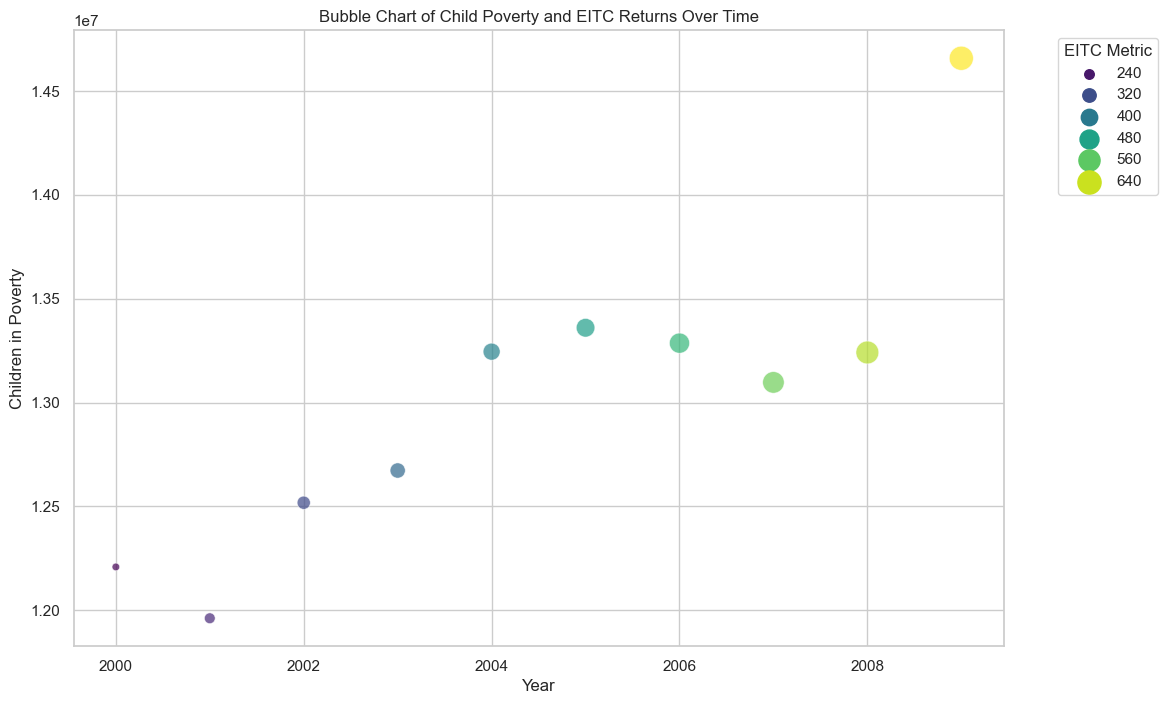

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data is stored in the variable 'sorted_data'
sorted_data = merged_us_data.sort_values(by='TimeFrame')

# Filter data if needed
sorted_data = sorted_data.dropna(subset=['Children_in_Poverty', 'EITC_id'])

# Set the style for the plot
sns.set(style="whitegrid")

# Create a scatter plot with bubble size and color representing different metrics
plt.figure(figsize=(12, 8))
bubble_chart = sns.scatterplot(
    x='TimeFrame',
    y='Children_in_Poverty',
    size='EITC_id',  # Change to the desired metric for bubble size
    hue='EITC_id',   # Change to the desired metric for bubble color
    sizes=(30, 300),  # Adjust the size range as needed
    data=sorted_data,
    palette='viridis',  # Change to a different colormap if desired
    alpha=0.7,
    edgecolor='w',
    linewidth=0.5
)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Children in Poverty')
plt.title('Bubble Chart of Child Poverty and EITC Returns Over Time')

# Adding legend
bubble_chart.legend(title='EITC Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

plt.close()

In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML

# Assuming your data is stored in the variable 'merged_us_data'
sorted_data = merged_data.sort_values(by='TimeFrame')

# Filter data if needed
sorted_data = sorted_data.dropna(subset=['Children_in_Poverty', 'data_Lagged', 'Percent_Child_Poverty'])

# Set the style for the plot
sns.set(style="whitegrid")

# Create an initial empty scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

# Adding labels and title
plt.xlabel('Children in Poverty')
plt.ylabel('Lagged Data')
plt.title('Animated Scatter Plot of Children in Poverty and Lagged Data Over Time')

# Function to update the plot for each frame
def update(frame):
    # Filter data for the current year
    current_data = sorted_data[sorted_data['TimeFrame'] == frame]

    # Clear previous scatter plot
    ax.clear()

    # Create a new scatter plot
    ax.scatter(
        x=current_data['Percent_Child_Poverty'],
        y=current_data['data_Lagged'],
        s=current_data['Children_in_Poverty']*.01,  # Adjust size as needed
        cmap='viridis', alpha=0.7, edgecolor='w', linewidth=0.5
    )

    # Set dynamic axis limits
    x_min, x_max = sorted_data['Percent_Child_Poverty'].min(), sorted_data['Percent_Child_Poverty'].max()
    y_min, y_max = sorted_data['data_Lagged'].min(), sorted_data['data_Lagged'].max()

    # Add some padding to the limits if desired
    x_padding = 0.1 * (x_max - x_min)
    y_padding = 0.1 * (y_max - y_min)

    ax.set_xlim(x_min - x_padding, x_max + x_padding)
    ax.set_ylim(y_min - y_padding, y_max + y_padding)

# Animate the plot
animation = FuncAnimation(fig, update, frames=sorted_data['TimeFrame'].unique(), blit=False, interval=1500)

# Uncomment the following line if you want to save the animation as a video
# animation.save('animated_scatter_plot.mp4', writer='ffmpeg')

video = animation.to_html5_video()
html = display(HTML(video))

display(html)

plt.close()


NameError: name 'merged_data' is not defined

In [31]:
# advanced scatterplot animation : multiple points moving with labels saved as a gif

size=100
u=np.random.multivariate_normal([1,1],[[1, 0.5], [0.5, 1]],size=size).reshape(1,-1)
v=np.random.multivariate_normal([1,1],[[2, 1], [1, 2]],size=size).reshape(1,-1)
w=np.random.multivariate_normal([1,1],[[4, 2], [2, 4]],size=size).reshape(1,-1)

data=pd.DataFrame(np.vstack([u,v,w]),index=['small','medium','large'])
easing.Eased(data).scatter_animation2d(speed=0.5,label=True,plot_kws={'alpha':0.5},destination='ScatterTest.gif')


In [45]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML
import seaborn as sns
import pandas as pd
import numpy as np
import easing_functions

# Assuming your data is stored in the variable 'merged_us_data'
sorted_data = merged_data.sort_values(by='TimeFrame')

# Filter data if needed
sorted_data = sorted_data.dropna(subset=['Children_in_Poverty', 'data_Lagged', 'Percent_Child_Poverty'])

# Set the style for the plot
sns.set(style="whitegrid")

# Create an initial empty scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

# Adding labels and title
plt.xlabel('Children in Poverty')
plt.ylabel('Lagged Data')
plt.title('Animated Scatter Plot of Children in Poverty and Lagged Data Over Time')

# Function to ease animation progress
def ease(t):
    return easing_functions.easeInOutCubic(t)

# Function to interpolate positions between frames
def interpolate_positions(current_data, next_data, alpha):
    # Interpolate between current and next positions
    x_interpolated = (1 - alpha) * current_data['Percent_Child_Poverty'] + alpha * next_data['Percent_Child_Poverty']
    y_interpolated = (1 - alpha) * current_data['data_Lagged'] + alpha * next_data['data_Lagged']
    return x_interpolated, y_interpolated

# Function to update the plot for each frame
def update(frame):
    # Filter data for the current year
    current_data = sorted_data[sorted_data['TimeFrame'] == frame]

    # Clear previous scatter plot
    ax.clear()

    # Create a new scatter plot with interpolated positions
    if frame < len(sorted_data['TimeFrame'].unique()) - 1:
        next_frame = frame + 1
        next_data = sorted_data[sorted_data['TimeFrame'] == next_frame]
        alpha = ease(frame / len(sorted_data['TimeFrame'].unique()))

        x_interpolated, y_interpolated = interpolate_positions(current_data, next_data, alpha)

        ax.scatter(
            x=x_interpolated,
            y=y_interpolated,
            s=current_data['Children_in_Poverty'] * 0.01,  # Adjust size as needed
            c='blue', alpha=0.7, edgecolor='w', linewidth=0.5
        )

        # Set dynamic axis limits
        x_min, x_max = sorted_data['Percent_Child_Poverty'].min(), sorted_data['Percent_Child_Poverty'].max()
        y_min, y_max = sorted_data['data_Lagged'].min(), sorted_data['data_Lagged'].max()

        # Add some padding to the limits if desired
        x_padding = 0.1 * (x_max - x_min)
        y_padding = 0.1 * (y_max - y_min)

        ax.set_xlim(x_min - x_padding, x_max + x_padding)
        ax.set_ylim(y_min - y_padding, y_max + y_padding)

# Animate the plot
animation = FuncAnimation(fig, update, frames=sorted_data['TimeFrame'].unique()[:-1], blit=False, interval=1500)

# Uncomment the following line if you want to save the animation as a video
# animation.save('animated_scatter_plot.mp4', writer='ffmpeg')

video = animation.to_html5_video()
html = display(HTML(video))

display(html)

plt.close()

None

In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML
import seaborn as sns
import numpy as np

# Assuming your data is stored in the variable 'merged_data'
sorted_data = merged_data.sort_values(by='TimeFrame')

# Filter data if needed
sorted_data = sorted_data.dropna(subset=['Children_in_Poverty', 'data_Lagged', 'Percent_Child_Poverty'])

# Set the style for the plot
sns.set(style="whitegrid")

# Create an initial empty scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

# Adding labels and title
plt.xlabel('Percent Child Poverty')
plt.ylabel('Lagged Data')
plt.title('Animated Scatter Plot of Percent Child Poverty and Lagged Data Over Time')

# Interpolate data for smoother animation
interp_frames = 100  # Number of interpolated frames between actual frames

# Function to update the plot for each frame
def update(frame):
    # Filter data for the current year
    current_data = sorted_data[sorted_data['TimeFrame'] == frame]

    # Interpolate points for smoother animation
    t = np.linspace(0, 1, interp_frames)
    x_interp = np.interp(t, [0, 1], [current_data['Percent_Child_Poverty'].iloc[0], current_data['Percent_Child_Poverty'].iloc[-1]])
    y_interp = np.interp(t, [0, 1], [current_data['data_Lagged'].iloc[0], current_data['data_Lagged'].iloc[-1]])

    # Clear previous scatter plot
    ax.clear()

    # Create a new scatter plot
    ax.scatter(
        x=x_interp,
        y=y_interp,
        s=current_data['Children_in_Poverty'].mean() * 0.01,  # Adjust size as needed
        cmap='viridis', alpha=0.7, edgecolor='w', linewidth=0.5
    )

    # Set dynamic axis limits
    x_min, x_max = sorted_data['Percent_Child_Poverty'].min(), sorted_data['Percent_Child_Poverty'].max()
    y_min, y_max = sorted_data['data_Lagged'].min(), sorted_data['data_Lagged'].max()

    # Add some padding to the limits if desired
    x_padding = 0.1 * (x_max - x_min)
    y_padding = 0.1 * (y_max - y_min)

    ax.set_xlim(x_min - x_padding, x_max + x_padding)
    ax.set_ylim(y_min - y_padding, y_max + y_padding)

# Animate the plot
animation = FuncAnimation(fig, update, frames=sorted_data['TimeFrame'].unique(), blit=False, interval=1500)

# Uncomment the following line if you want to save the animation as a video
# animation.save('animated_scatter_plot.mp4', writer='ffmpeg')

video = animation.to_html5_video()
html = display(HTML(video))

display(html)


NameError: name 'merged_data' is not defined

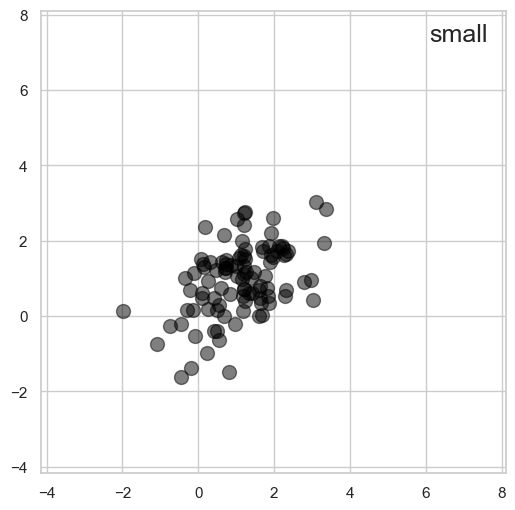

In [49]:

size=100
u=np.random.multivariate_normal([1,1],[[1, 0.5], [0.5, 1]],size=size).reshape(1,-1)
v=np.random.multivariate_normal([1,1],[[2, 1], [1, 2]],size=size).reshape(1,-1)
w=np.random.multivariate_normal([1,1],[[4, 2], [2, 4]],size=size).reshape(1,-1)

data=pd.DataFrame(np.vstack([u,v,w]),index=['small','medium','large'])
easing.Eased(data).scatter_animation2d(speed=0.5,label=True,plot_kws={'alpha':0.5},destination='ScatterTest.gif')

In [ ]:
print(u)

In [ ]:
data=pd.DataFrame(np.vstack([u,v,w]),index=['small','medium','large'])
print(data)

In [ ]:
easing.Eased(data).scatter_animation2d(speed=0.5,label=True,plot_kws={'alpha':0.5},destination='ScatterTest.gif')